In [1]:
import h5py
import torch
import pyfftw
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.signal import peak_widths, medfilt

In [2]:
def get_window(PSD):
    """Calculates window to calculate SNR for signal.

    Args:
        PSD: PSD: 1D array of injected PSD data.

    Returns:
        window: A tuple[peak, left, right] containing:
            peak: index where peak of data is.
            left: index where the left bin of the signal is.
            right: index where the right bin of the signal is.
    """
    # Applies median filter to data to remove any outliers
    PSD = medfilt(PSD)  

    # We calculate the window for the first pass of the function (injected PSD)
    peak = np.argmax(PSD)
    _, _, left, right = peak_widths(PSD, [peak], rel_height=0.7, wlen=20001)
    window = (peak, int(left[0]), int(right[0]))

    return window


def get_snr(PSD, window):
    """Calculates SNR of PSD.

    Args:
        PSD: 1D array of PSD data.
        window: A tuple[peak, left, right] containing:
            peak: index where peak of data is.
            left: index where the left bin of the signal is.
            right: index where the right bin of the signal is.

    Returns:
        SNR: Signal-to-noise ratio of signal.
    """
    
    peak       = window[0]
    left_edge  = window[1]
    right_edge = window[2]
    noise_bin  = 7500 #5000
    
    signal = np.mean(PSD[left_edge : right_edge + 1])

    noise  = np.concatenate([PSD[left_edge - noise_bin : left_edge - 200],
                             PSD[right_edge + 201      : right_edge + noise_bin + 1]])
    
    mean_noise = np.mean(noise)
    noise_std  = np.std(noise)

    snr = (signal - mean_noise) / noise_std
 
    return snr

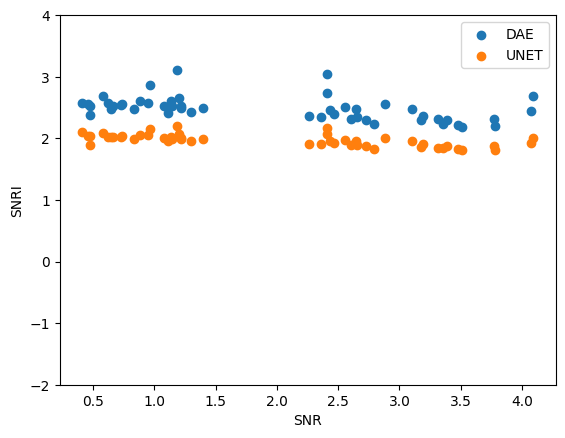

In [3]:
### Plots SNRI as a function of SNR for different signal sizes

# Setting directory to pull files from
directory  = Path('Denoised_science/')
dae_files  = sorted(directory.glob(f'*dae.h5'))
unet_files = sorted(directory.glob(f'*unet.h5'))

def get_snri_data(file_list):

    snr  = []
    snri = []

# Currently 59 files with signal size ranging from 0 to 1.5e3

    for i, filename in enumerate(file_list[:]):
        f = h5py.File(filename, 'r')

        # Data = log10(x + 1), so must do 10 ** (Data) - 1
        noise    = np.exp(f['input'][:]) - 1 
        denoised = np.exp(f['denoised'][:]) - 1
        injected = np.exp(f['injected'][:]) - 1
        
        # Basing our signal window off the injected signal
        window = get_window(injected) 

        # Calculating SNR for noise PSD and denoised PSD
        noise_snr    = get_snr(noise, window)
        denoised_snr = get_snr(denoised, window)

        snr.append(noise_snr)
        snri.append(denoised_snr / noise_snr)

    return snr, snri

# First point has no injected signal so don't count it
# One thing to keep in mind is that the first few signals are really small and don't really give an accurate SNRI
# change start >= 10 to get more accurate plot 
start  = 10      
dae_snr, dae_snri   = get_snri_data(dae_files[start:])
unet_snr, unet_snri = get_snri_data(unet_files[start:])


plt.figure()
plt.scatter(dae_snr, dae_snri, label='DAE')
plt.scatter(unet_snr, unet_snri, label='UNET')
plt.ylabel('SNRI')
plt.xlabel('SNR')
plt.ylim(-2, 4)
plt.legend()
plt.show()

[1.         1.03448276 1.06896552 1.10344828 1.13793103 1.17241379
 1.20689655 1.24137931 1.27586207 1.31034483 1.34482759 1.37931034
 1.4137931  1.44827586 1.48275862 1.51724138 1.55172414 1.5862069
 1.62068966 1.65517241 1.68965517 1.72413793 1.75862069 1.79310345
 1.82758621 1.86206897 1.89655172 1.93103448 1.96551724 2.
 2.03448276 2.06896552 2.10344828 2.13793103 2.17241379 2.20689655
 2.24137931 2.27586207 2.31034483 2.34482759 2.37931034 2.4137931
 2.44827586 2.48275862 2.51724138 2.55172414 2.5862069  2.62068966
 2.65517241 2.68965517]


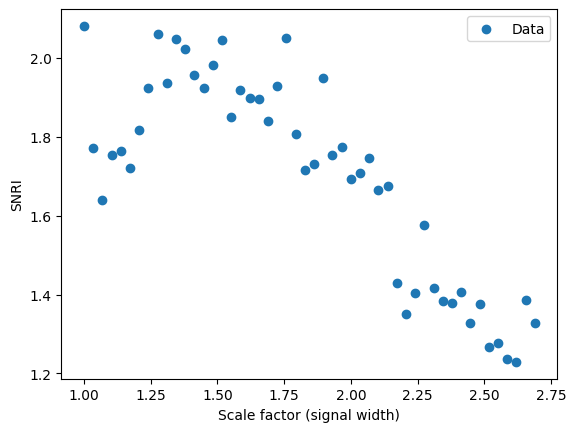

In [4]:
### Plots SNRI as a function of Scale factor (signal width)

# Setting directory to pull files from
directory = Path('Denoised_science_signalWidth/')
file_list = sorted(directory.glob(f'*dae.h5'))

snri  = []
scale = []

# Currently 49 files with scale_factor ranging from 0.5 to ~2.6
for i, filename in enumerate(file_list[:]):
    f = h5py.File(filename, 'r')

    # Data = log10(x + 1), so must do 10 ** (Data) - 1
    noise    = np.exp(f['input'][:]) - 1 
    denoised = np.exp(f['denoised'][:]) - 1
    injected = np.exp(f['injected'][:]) - 1
    
    scale_factor = f['injected'].attrs['scale_factor']
    scale.append(scale_factor)
    
    # Basing our signal window off the injected signal
    window = get_window(injected) 

    # Calculating SNR for noise PSD and denoised PSD
    noise_snr    = get_snr(noise, window)
    denoised_snr = get_snr(denoised, window)

    snri.append(denoised_snr / noise_snr)

scale = np.array(scale[:])
snri  = np.array(snri[:])
print(scale)
# Setting exponential function to fit the data
def negative_exponential(x, A, k, C):
    return A * np.exp(-k * x) + C

# Initial guesses for parameters (A, k, C)
p0 = [20, 2, 2] 
# params, _ = curve_fit(negative_exponential, scale, snri, p0=p0)

# Extracting the fitted parameters
# 
# A_fit, k_fit, C_fit = params

plt.figure()
plt.scatter(scale, snri, label='Data')
# plt.plot(scale, negative_exponential(scale, A_fit, k_fit, C_fit), c='red', label=f'LOB')
plt.ylabel('SNRI')
plt.xlabel('Scale factor (signal width)')
plt.legend()
plt.show()

0it [00:00, ?it/s]

7545090_science with a signal size of 150.0


1it [00:07,  7.18s/it]

7545096_science with a signal size of 1500.0


2it [00:17,  8.76s/it]

7545102_science with a signal size of 15000.0


3it [00:27,  9.32s/it]

7545110_science with a signal size of 150000.0


4it [00:37,  9.58s/it]

7545117_science with a signal size of 1500000.0


5it [00:47,  9.41s/it]


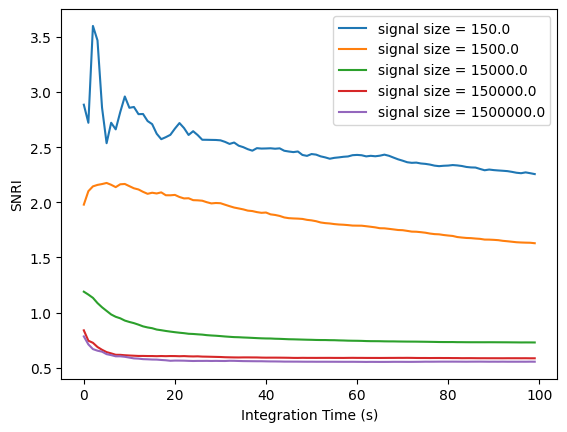

In [5]:
### Plots SNRI as function of integration time for different signal sizes

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sampling_freq = int(400e3)
batchsize     = 1
input_size    = sampling_freq // 2

def read_loader(ADMXfile):
    """Reads in Time-Series data and converts to scaled down PSD.

    Args:
        ADMXfile: Opened .h5 file with ['input'] and ['injected'] channels.

    Returns:
        train_loader: Concatenated array of train and target 1D arrays.
        
    """
    train = ADMXfile['input'][:]
    train = train.reshape(-1, sampling_freq)
    train = np.abs(pyfftw.interfaces.scipy_fft.rfft(train)[:, 1:]) ** 2
    # Trained better with log1p than log10 
    train = np.log1p(train)
    train = train.reshape(-1, batchsize, input_size)
    
    target = ADMXfile['injected'][:]
    target = target.reshape(-1, sampling_freq)
    target = np.abs(pyfftw.interfaces.scipy_fft.rfft(target)[:, 1:]) ** 2
    target = np.log1p(target)
    target = target.reshape(-1, batchsize, input_size)

    train_loader = np.concatenate([train, target], axis=1)

    return train_loader

# Loading in model 
model = torch.load(f'UNET.pth', map_location=DEVICE, weights_only=False)
model.eval()

# Setting directory to pull files from
directory = Path('integrationTime_Science/')
file_list = sorted(directory.glob('*.h5'))

# Range for integration time
seconds = np.arange(0, 100)

# Currently only 5 files with sig_size = [1.5e2, 1.5e3, 1.5e4, 1.5e5, 1.5e6]
for ii, fname in tqdm(enumerate(file_list[:])): 
    ADMXfile     = h5py.File(fname,'r')
    train_loader = read_loader(ADMXfile)
    sig_size = ADMXfile['injected'].attrs['sig_size']

    print(f'{fname.stem} with a signal size of {sig_size}')

    noise    = []
    denoised = []
    injected = []
    snri = []

    # Inputting data into ML model and getting denoised output
    for i, batch in enumerate(train_loader):
        inputarr, targetarr = (batch[:batchsize], batch[batchsize:])

        input_seq  = torch.from_numpy(inputarr).unsqueeze(0)
        input_seq  = input_seq.float().to(DEVICE)

        output_seq = model(input_seq).detach().cpu().numpy()
        
        # Appending the 3 arrays to their corresponding lists
        denoised.append(output_seq.flatten())
        injected.append(targetarr.flatten())
        noise.append(inputarr.flatten())
        
    # Basing our window size after taking the stacked mean on injected signal
    window = get_window(np.exp(np.mean(np.array(injected[:]), axis=0)) - 1)
    
    for i in seconds:
        # Scaling back to regular values and taking mean from index 0 to i + 1 for a total of 100 seconds
        # For each loop we add an extra second to average from
        noise_psd    = np.exp(np.mean(np.array(noise[:i + 1]), axis=0)) - 1
        denoised_psd = np.exp(np.mean(np.array(denoised[:i + 1]), axis=0)) - 1

        noise_snr    = get_snr(noise_psd, window)
        denoised_snr = get_snr(denoised_psd, window)

        snri.append(denoised_snr / noise_snr)
    
    plt.plot(seconds, snri, label=f'signal size = {sig_size}')
    plt.xlabel('Integration Time (s)')
    plt.ylabel('SNRI')
    # plt.ylim((0, 35))
    plt.legend(loc='upper right')
plt.show()